# 시계열분석

## 7장 ARIMA(정상성확인)
- Autoregressive Integrated Moving Average
- Stationary(정상), Non-Stationary(비정상) 시계열 중 Stationary 시계열에 사용해야함
- 정상시계열로 변환을 해주어야 ARIMA 모델이 효과적이다.
    - Stationary 데이터 특성
        - 연속되는 숫자들의 [평균, 분산, 공분산]이 시간에 따라 변하지 않음
- Differencing(차분)을 1번이상해주어서 비정상시계열을 정상시계열로 만드는 단계가 필요하다.
- statsmodel.api.tsa.statespace.SARIMAX()
- 모델
    - 정상시계열 ARIMA(p,d,q)
    - 비정상시계열 ARIMA(p,d,q)(P,D,Q)m
        - m은 1년의 개월 수

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

---
---

### 앞 데이터를 통해 간단한 예시 확인

In [2]:
import statsmodels.api as sm

In [3]:
# 데이터 불러오기
airline = pd.read_csv('./data/airline_passengers.csv', index_col = 'Month', parse_dates=True)
train = airline[:'1959']
test = airline['1960':]
y_hat = test.copy()

In [4]:
# 모델 만들기
arima = sm.tsa.statespace.SARIMAX(
    train['Thousands of Passengers'],
    order=(2,1,1),
    seasonal_order=(0,1,0,12),
    enforce_stationarity=False,
    enforce_invertibility=False)

C:\Users\rbtkd\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\rbtkd\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [5]:
# 모델 피팅
arima_result = arima.fit()

In [6]:
# 모델 예측
# forecast, predict 둘다 가능
# forest와 달리 predict는 인덱스를 받는다.
# dynamic = True 예측한 결과를 계속해서 쓰는 것 (여러개의 데이터를 예측하기 위해)
y_hat['ARIMA'] = \
arima_result.predict(start='1960-01-01',
                    end='1960-12-01',
                    dynamic = True)

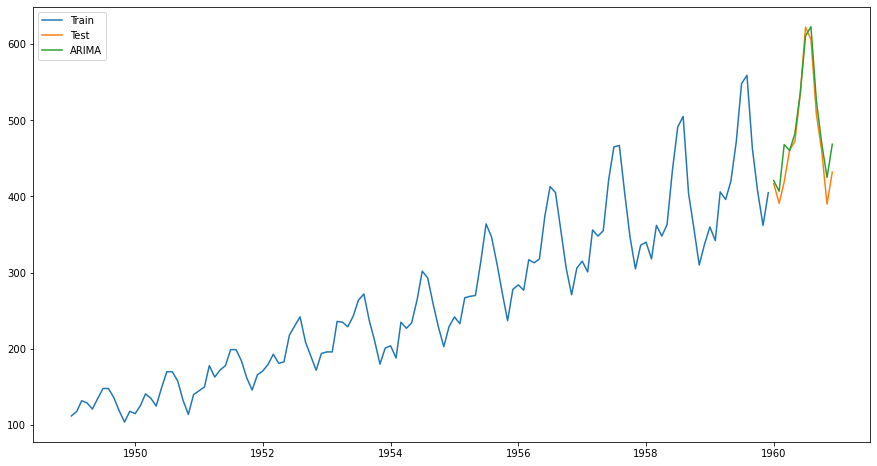

In [7]:
# 그래프로 확인
plt.figure(figsize=(15,8))
plt.plot(train['Thousands of Passengers'], label='Train')
plt.plot(test['Thousands of Passengers'], label='Test')
plt.plot(y_hat['ARIMA'], label='ARIMA')
plt.legend()

## 거의 일치한다.

In [8]:
# 모델평가(RMSE)
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(test['Thousands of Passengers'],y_hat['ARIMA']))

22.650964246977274

---
---

# ARIMA 실습

### 01. 데이터 불러오기

In [9]:
df = \
pd.read_csv('./data/monthly-milk-production.csv',index_col='Month',parse_dates=True)
df.head()

,pounds per cow
Month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


<AxesSubplot:xlabel='Month'>

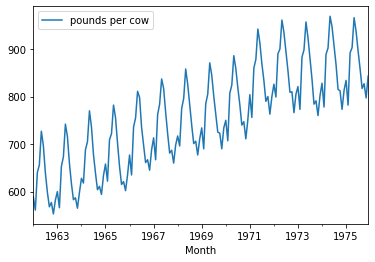

In [10]:
# 그래프로 확인
df.plot()
## seasonality, trend 있음.

---

### 02. 정상성 확인

In [11]:
timeseries = df['pounds per cow']

<AxesSubplot:xlabel='Month'>

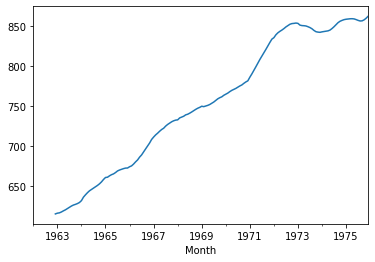

In [12]:
# 1년으로 rolling해서 mean 확인 => stationary 하지 않다.
timeseries.rolling(12).mean().plot()
## 아래같은 trend 가지고 있음

<AxesSubplot:xlabel='Month'>

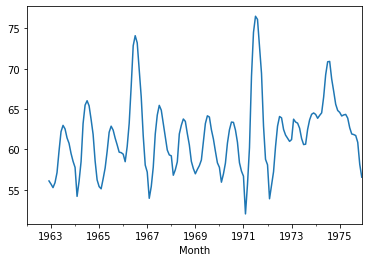

In [13]:
# varience가 일정하지 않음 => stationaty 하지 않다.
timeseries.rolling(12).std().plot()

In [14]:
# decomposition 확인
# decomposition 확인
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['pounds per cow'])

<Figure size 1080x504 with 0 Axes>

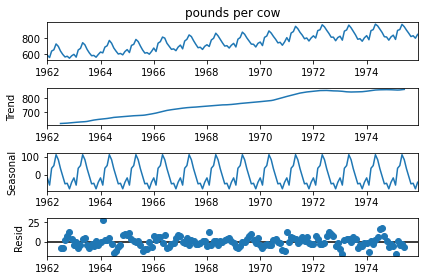

In [15]:
fig = plt.figure(figsize=(15,7))
fig = decomposition.plot();

#### 02-1 adfuller 활용 정상성 확인
- 귀무가설 : 해당 시계열이 비정상 시계열이다.

In [16]:
from statsmodels.tsa.stattools import adfuller

In [17]:
result = adfuller(df['pounds per cow'])
result
## pvalue는 result[1]에 해당하는 0.627이다. 0.05보다 작아야 stationary 하다고 봄

(-1.3038115874221246,
 0.627426708603034,
 13,
 154,
 {'1%': -3.473542528196209,
  '5%': -2.880497674144038,
  '10%': -2.576878053634677},
 1115.1730447395112)

In [18]:
# 함수로 만들기
def adf_check(ts):
    result = adfuller(ts)
    if result[1] <= 0.05:
        print('Stationary, pvalue={}'.format(result[1]))
    else:
        print('Non-Stationary, pvalue={}'.format(result[1]))

In [19]:
adf_check(df['pounds per cow'])

Non-Stationary, pvalue=0.627426708603034


#### 02-2 kpss 통한 정상성 확인
- 귀무가설 : 해당 시계열이 정상 시계열이다.

In [20]:
from statsmodels.tsa.stattools import kpss

In [21]:
result = kpss(df['pounds per cow'])
result

C:\Users\rbtkd\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)


(1.173729491945144,
 0.01,
 14,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [22]:
# 함수로 만들기
def kpss_check(ts):
    result = kpss(ts)
    if result[1] > 0.05:
        print('Stationary, pvalue={}'.format(result[1]))
    else:
        print('Non-Stationary, pvalue={}'.format(result[1]))

In [23]:
kpss_check(df['pounds per cow'])

Non-Stationary, pvalue=0.01


C:\Users\rbtkd\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)


---

## 03. differencing(차분)
- shift 이용

### 03-1 그냥 차분

In [24]:
# 1차원 differencing
df['1st diff'] = df['pounds per cow'] - df['pounds per cow'].shift(1)
df.head()

,pounds per cow,1st diff
Month,,
1962-01-01,589,NaN
1962-02-01,561,-28.0
1962-03-01,640,79.0
1962-04-01,656,16.0
1962-05-01,727,71.0


In [25]:
# 정상성확인 - dropna() 해주어야 check가 가능
adf_check(df['1st diff'].dropna())

Stationary, pvalue=0.03006800400178688


<AxesSubplot:xlabel='Month'>

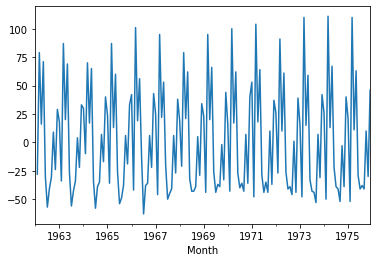

In [26]:
# 시각화
df['1st diff'].plot()

In [27]:
# 2차 differencing
df['2nd diff'] = df['1st diff'] - df['1st diff'].shift(1)

<AxesSubplot:xlabel='Month'>

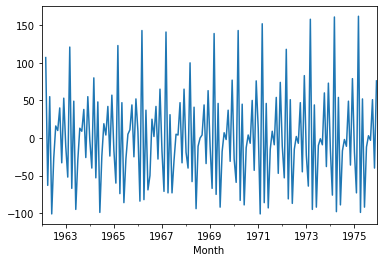

In [28]:
df['2nd diff'].plot()

In [29]:
# 정상성 확인
adf_check(df['2nd diff'].dropna())

Stationary, pvalue=1.1126989332083069e-26


### 03-2. Seasonal differencing

In [30]:
df['seasonal diff'] = df['pounds per cow'] - df['pounds per cow'].shift(12)

<AxesSubplot:xlabel='Month'>

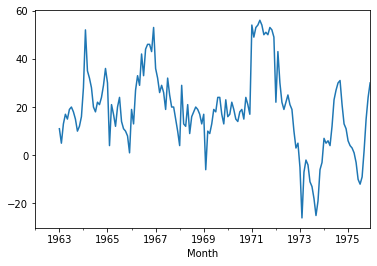

In [31]:
df['seasonal diff'].plot()

In [32]:
adf_check(df['seasonal diff'].dropna())

Non-Stationary, pvalue=0.16079880527711304


### 03-3. 1차 diff에 seasonal differencing

In [33]:
df['seasonal 1st diff'] = df['1st diff'] - df['1st diff'].shift(12)

<AxesSubplot:xlabel='Month'>

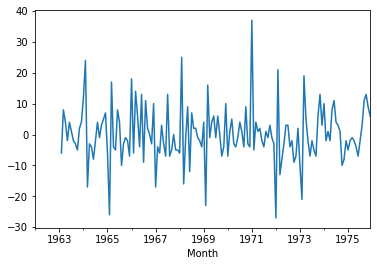

In [34]:
df['seasonal 1st diff'].plot()

In [35]:
adf_check(df['seasonal 1st diff'].dropna())

Stationary, pvalue=1.86542343187882e-05


#### 해석
- d=1(차분), D=1(계절성차분) 쓰면 된다.

---

## 04. acf, pacf 그래프
- 정상성 여부 확인
    - 정상성을 나타내지 않는 데이터에서는 ACF가 느리게 감소
    - 정상성을 나타내는 시계열에서는, ACF가 비교적 빠르게 0으로 떨어진다.
- p,q 결정
![image](https://user-images.githubusercontent.com/80219821/132940195-8f3b5c20-6233-4c1e-8335-7d1ace51f5d0.png)


In [50]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

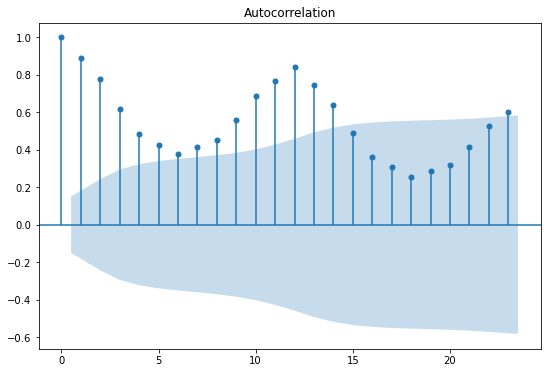

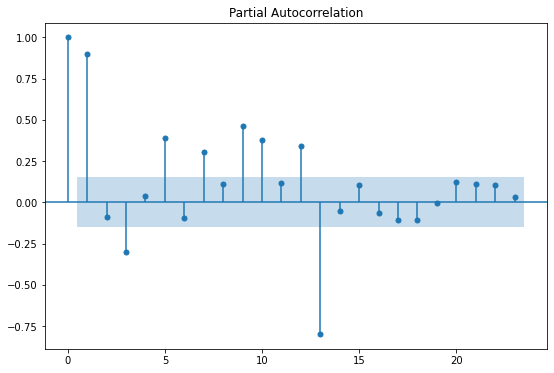

In [65]:
# 원래 그래프 확인
plot_acf(df['pounds per cow']);
plot_pacf(df['pounds per cow']);

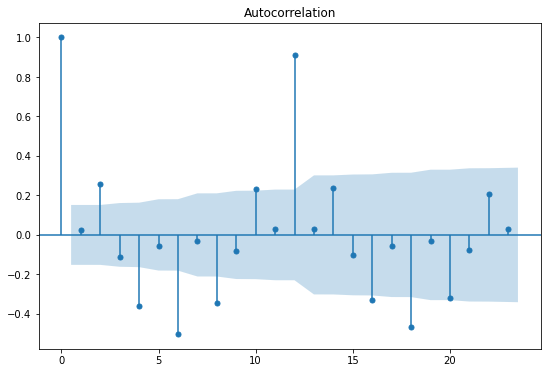

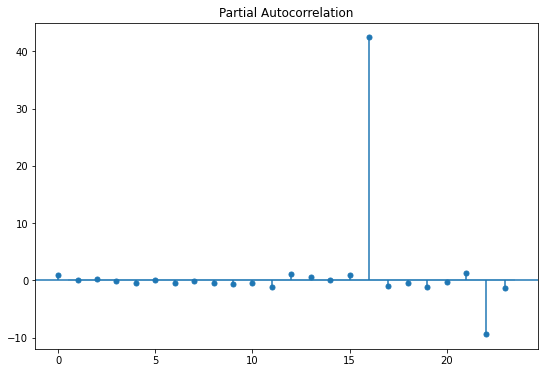

In [64]:
# 1st diff
plot_acf(df['1st diff'].dropna());
plot_pacf(df['1st diff'].dropna());

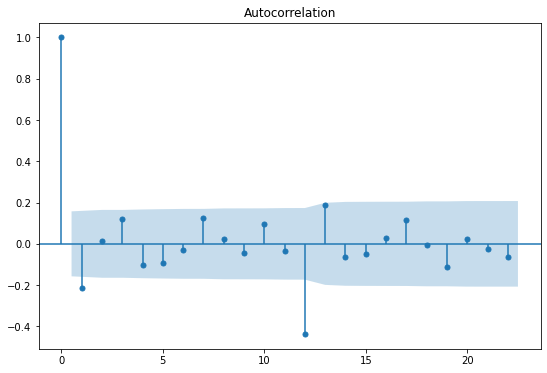

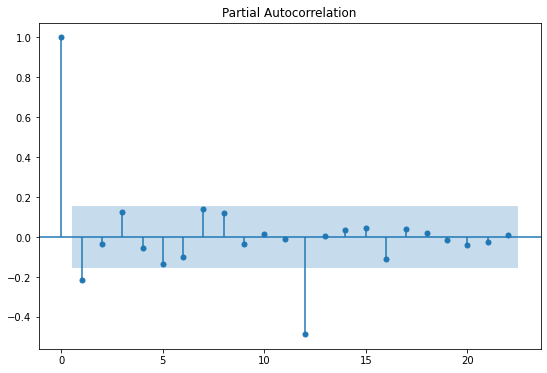

In [63]:
# seasonal 1st diff
plot_acf(df['seasonal 1st diff'].dropna());
plot_pacf(df['seasonal 1st diff'].dropna());

#### 해석
- 1st diff와 seasonal 1st diff 모두 acf그래프에서 빨리 0에 수렴함으로 정상성시계열이다.
- 1st diff 기준으로 p=0, q=0이 적당하다
- seasonal 1st diff 기준으로 P는 1, Q는 1이 적당하다


#### 최종
- P=1, D=1, Q=1
- p=0, d=1, q=0
- 하지만 그래프로 p,q구하는 것은 쉽지 않기에 SARMAX에서 그리드서치 이용하는 것이 좋음

---

## 05. ARIMA 모델
- trend : constant를 가지고 있는지(c - constant / nc - no constant)
    - 만약 결과레포트에서 상수항의 pvalue가 0.05보다 높다면 n 해주어야 함

In [77]:
# 모델만들기
model = sm.tsa.statespace.SARIMAX(df['pounds per cow'],
                                  trend='n',
                                 order=(0,1,0),
                                 seasonal_order=(1,1,1,12))

C:\Users\rbtkd\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\rbtkd\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [78]:
# 모델 fitting
result = model.fit()

In [89]:
# 결과 report
result.summary()
## AIC와 BIC를 봐야한다. (모델의 성능) 작을수로 좋다.
# P,Q에 대한 coef만 나온 것 확인 가능
# 각 변수 p-value보면서 적당한지 확인해야 함

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                       pounds per cow   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -534.065
Date:                              Sat, 11 Sep 2021   AIC                           1074.131
Time:                                      16:54:52   BIC                           1083.261
Sample:                                  01-01-1962   HQIC                          1077.839
                                       - 12-01-1975                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0449      0.106     -0.422      0.673      -0.253       0.163
ma.S.L12      -0.5860      0.102     -5.762      0.000      -0.785      -0.387
sigma2        55.5118      5.356     10.365      0.000      45.015      66.009
===================================================================================
Ljung-Box (L1) (Q):                   8.13   Jarque-Bera (JB):                32.04
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.77
Prob(H) (two-sided):                  0.18   Kurtosis:                         4.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

---

## 06. 잔차분석

<AxesSubplot:xlabel='Month'>

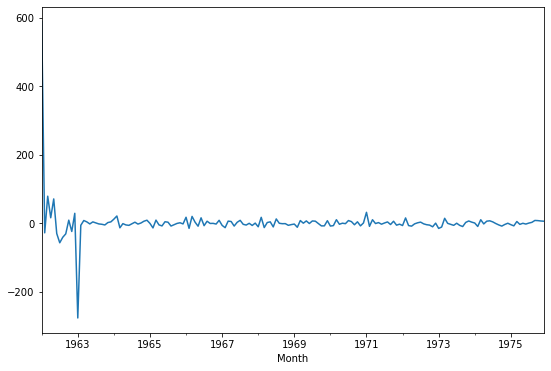

In [80]:
# 잔차플롯
result.resid.plot()

## 초반에는 샘플이 적으니까 resid가 클수밖에 없고,
## 나중에 갈수록 resid 적어지는 것 확인 가능

<AxesSubplot:ylabel='Density'>

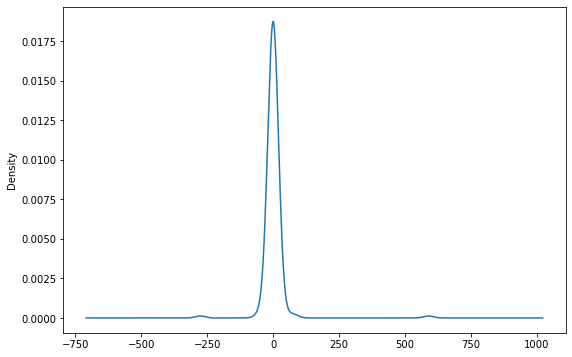

In [91]:
result.resid.plot(kind='kde')
# bias 되지 않는 noise 데이터라는 뜻 
# 모델 피팅이 어느정도 잘되었다는 뜻

- 정상성 검토

In [87]:
adf_check(result.resid)

Stationary, pvalue=0.0


- 정규성 검토

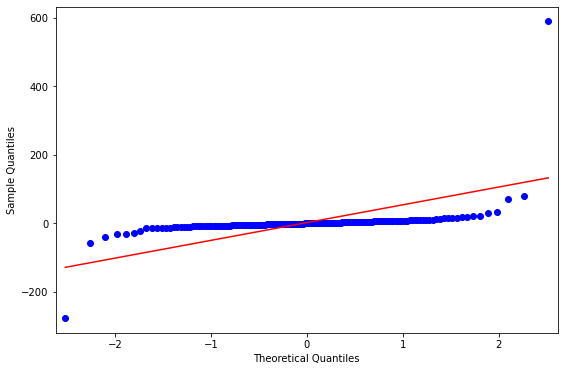

In [82]:
# qqplot 통한 정규성 검토
from statsmodels.graphics.gofplots import qqplot

qqplot(result.resid, line='s')
plt.show()

## 정규성이 있는것처럼 보이기도 한다. 하지만 shapiro로 확실히 확인해야 함

In [85]:
# shapiro 통한 정규성 검토
from scipy.stats import shapiro, normaltest
shapiro(result.resid)
## p-value가 0.05보다 작기 떄문에 귀무가설을 기각한ㄷ. 즉, 표본이 정규분포를 따르지 않는다.

ShapiroResult(statistic=0.248121440410614, pvalue=1.0137615131437873e-25)

- 자기상관 확인

In [88]:
from statsmodels.stats.stattools import durbin_watson

durbin_watson(result.resid)
## 2에 가까울수록 auto correlation을 가지고 있지 않다는 가설을 채택할 수 있다.
## 보통 1.5~2.5 정도로 보는데 이정도면 자기상관관계를 가지고 있지 않다고 볼 수 있다.
## 0이면 양의 자기상관, 4면 음의 자기상관 가진다.

1.333533206600951

---

## 07. 예측

In [92]:
# 데이터 개수 확인
len(df['pounds per cow'])

168

In [93]:
# 예측
df['forecast'] = \
result.predict(start=150,
              end=168,
              dynamic=True)

<AxesSubplot:xlabel='Month'>

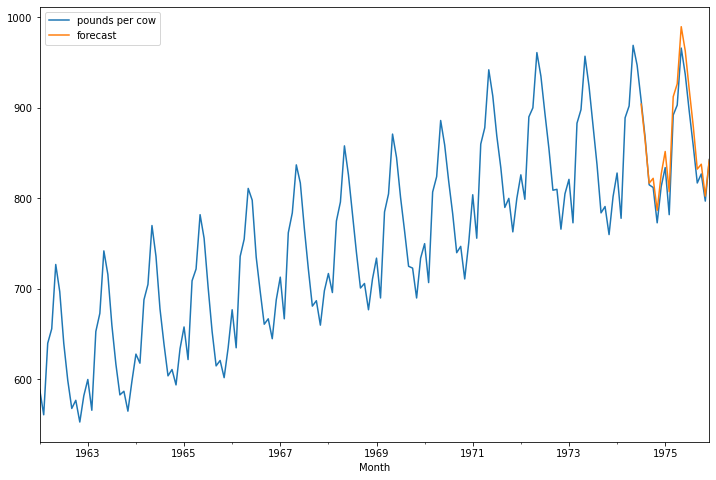

In [94]:
# 그래프로 확인
df[['pounds per cow', 'forecast']].plot(figsize=(12,8))

## 대체적으로 잘 따라가는 것 확인가능

In [109]:
# 모델 평가
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(df['pounds per cow'][150:],df['forecast'][150:]))

16.802385872841203

---
---

## 08. rolling forecast 실습 (그리드서치도 함)
- from statsmodels.tsa.arima_model import ARIMA

In [95]:
shampoo = pd.read_csv('./data/sales-of-shampoo.csv', index_col='Month', parse_dates=True)
shampoo.head()

,Sales of shampoo
Month,
1-01,266.0
1-02,145.9
1-03,183.1
1-04,119.3
1-05,180.3


In [96]:
# parsing이 안됨어 있음. 어떤게 월인지 모른다.
shampoo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36 entries, 1-01 to 3-12
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Sales of shampoo  36 non-null     float64
dtypes: float64(1)
memory usage: 576.0+ bytes


In [97]:
# dateparser 함수 정의
from datetime import datetime
def dateparser(x):
    return datetime.strptime('190'+x, "%Y-%m")
   
dateparser('1-01')

datetime.datetime(1901, 1, 1, 0, 0)

In [98]:
# datetimeindex로 잘 parsing 된 것 확인 가능
shampoo = pd.read_csv('./data/sales-of-shampoo.csv', index_col='Month', date_parser=dateparser)
shampoo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 1901-01-01 to 1903-12-01
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Sales of shampoo  36 non-null     float64
dtypes: float64(1)
memory usage: 576.0 bytes


In [99]:
# stationary 확인
adf_check(shampoo['Sales of shampoo'])

Non-Stationary, pvalue=1.0


In [100]:
# 1차 차분
shampoo['1st diff'] = shampoo['Sales of shampoo'] - shampoo['Sales of shampoo'].shift(1)

In [102]:
adf_check(shampoo['1st diff'].dropna())

## d = 1

Stationary, pvalue=1.7998574141687034e-10


<AxesSubplot:xlabel='Month'>

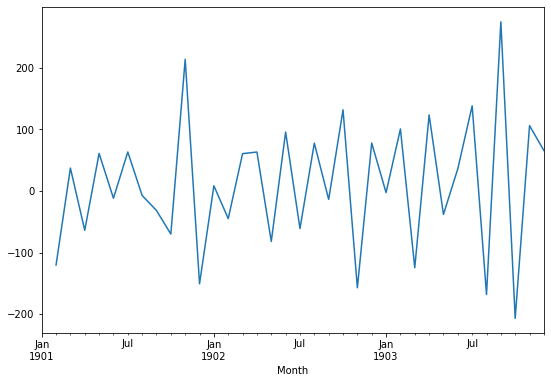

In [104]:
# 그래프로 확인해본 결과 seasonality는 잘 보이지 않는다.
shampoo['1st diff'].plot()

In [105]:
# 2차 차분 해보기
shampoo['2nd diff'] = shampoo['1st diff'] - shampoo['1st diff'].shift(1)
adf_check(shampoo['2nd diff'].dropna())

Stationary, pvalue=0.0039063349396599245


<AxesSubplot:xlabel='Month'>

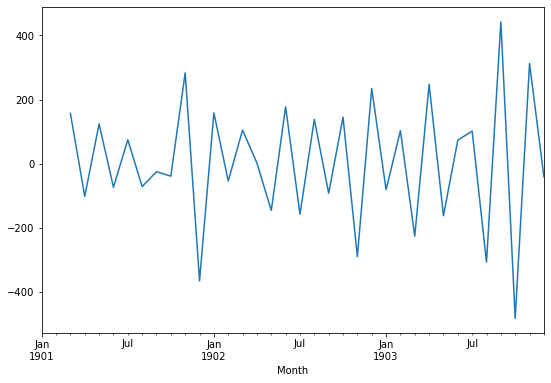

In [106]:
shampoo['2nd diff'].plot()

## d = 2
## 마찬가지로 seasonality 안보임

#### 해석 : d는 1or2

In [112]:
from statsmodels.tsa.arima_model import ARIMA

In [113]:
p = list(range(0,5))
d = [1,2]
q = list(range(0,5))

In [114]:
# 모든 조합 찾기
import itertools
pdq = list(itertools.product(p,d,q))
pdq

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 2, 4),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (2, 2, 4),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3),
 (3, 1, 4),
 (3, 2, 0),
 (3, 2, 1),
 (3, 2, 2),
 (3, 2, 3),
 (3, 2, 4),
 (4, 1, 0),
 (4, 1, 1),
 (4, 1, 2),
 (4, 1, 3),
 (4, 1, 4),
 (4, 2, 0),
 (4, 2, 1),
 (4, 2, 2),
 (4, 2, 3),
 (4, 2, 4)]

In [117]:
# 중간에 error가 날 수 있음으로 try, except 이용
for param in pdq:
    try:
        model = ARIMA(shampoo['Sales of shampoo'], order=param)
        result = model.fit()
        print('ARIMA{} - AIC:{}'.format(param, result.aic))
    except:
        pass

### ARIMA(4,2,2) 이 가장 좋은 모델

ARIMA(0, 1, 0) - AIC:430.87311187552797
ARIMA(0, 1, 1) - AIC:409.0126622410894
ARIMA(0, 1, 2) - AIC:399.6062611749037
ARIMA(0, 1, 3) - AIC:401.5384453922496
ARIMA(0, 1, 4) - AIC:403.1661066073749
ARIMA(0, 2, 0) - AIC:461.1578257086931
ARIMA(0, 2, 1) - AIC:424.5825157171076
ARIMA(1, 1, 0) - AIC:406.0222895923382
ARIMA(1, 1, 1) - AIC:402.46665241797984
ARIMA(1, 1, 2) - AIC:401.5247943797391
ARIMA(1, 1, 3) - AIC:403.5241728749513
ARIMA(1, 2, 0) - AIC:423.9000860377617
ARIMA(2, 1, 0) - AIC:403.62756411661564
ARIMA(2, 1, 1) - AIC:404.28621423306674
ARIMA(2, 2, 0) - AIC:412.9993824970403
ARIMA(2, 2, 1) - AIC:396.6526253922859
ARIMA(2, 2, 3) - AIC:389.6835425127406
ARIMA(3, 1, 0) - AIC:404.6924591816364
ARIMA(3, 1, 1) - AIC:406.13954439295037
ARIMA(3, 1, 4) - AIC:406.67979078488247
ARIMA(3, 2, 0) - AIC:410.9109265845766
ARIMA(3, 2, 1) - AIC:396.3062365835395
ARIMA(3, 2, 3) - AIC:406.1049294516407
ARIMA(4, 1, 0) - AIC:404.7867685567421
ARIMA(4, 1, 1) - AIC:406.5796403612163
ARIMA(4, 1, 2) - AI

In [119]:
# train,test 데이터 만들기
X = shampoo['Sales of shampoo'].values
size = int(len(X) * 0.66)
train, test = X[:size], X[size:]
len(train), len(test)

(23, 13)

In [120]:
history = [x for x in train]
predictions = []

In [121]:
for t in range(len(test)):
    model = ARIMA(history, order=(4,2,1))
    result = model.fit()
    output = result.forecast()#default는 1개만 예측
    yhat = output[0]#배열로 나오기때문에 첫번쨰값으로 해주어야 함
    predictions.append(yhat)
    history.append(test[t])

In [122]:
# 모델 평가

from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(test,predictions))

68.51918070033352

In [123]:
shampoo['Sales of shampoo'].describe()

## mean이 312고 std 148인데 rmse가 75면 거의 절반만큼 에러가 나는 것이다.. 
# 성능이 그리 좋지 않음

count     36.000000
mean     312.600000
std      148.937164
min      119.300000
25%      192.450000
50%      280.150000
75%      411.100000
max      682.000000
Name: Sales of shampoo, dtype: float64

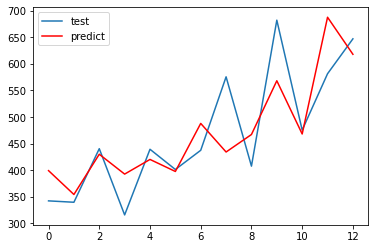

In [124]:
# 시각화
plt.plot(test, label='test')
plt.plot(predictions, color='red',label='predict')
plt.legend()
plt.show()